In [413]:

%pip install tensorflow

%pip install scikit-learn

%pip install gensim

%pip install warcio

%pip install xgboost

%pip install pandas


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgr

In [414]:
import pandas as pd
dataset_path = 'data/creditcard.csv'
data = pd.read_csv(dataset_path)

In [415]:
import numpy as np
import tensorflow as tf
import seaborn as sns

from tensorflow.keras import layers, Model
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping


import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.kernel_approximation import Nystroem

import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import precision_score

from sklearn.metrics import precision_recall_curve

from sklearn.manifold import TSNE


In [416]:
# Display the first few rows of the dataset
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [417]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

def preprocess_creditcard_data(data, outlier_removal=True, apply_pca=True, pca_variance=0.99):
    # 1. Split features and labels
    X = data.drop(columns=['Class'])
    y = data['Class']

    # 2. Create AE training set (use all class 0, no outlier removal)
    X_ae = X[y == 0].copy()

    # 3. For supervised models: optionally remove outliers from 'Amount'
    X_sup = X.copy()
    y_sup = y.copy()

    if outlier_removal:
        Q1 = X_sup['Amount'].quantile(0.25)
        Q3 = X_sup['Amount'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_mask = (X_sup['Amount'] >= lower_bound) & (X_sup['Amount'] <= upper_bound)

        X_sup = X_sup[outlier_mask]
        y_sup = y_sup[outlier_mask]

    # 4. Scale features using MinMaxScaler
    scaler = MinMaxScaler()
    X_sup_scaled = scaler.fit_transform(X_sup) #scaler.transform(X_sup)  # Use same scaler for consistency
    X_ae_scaled = scaler.transform(X_ae)

    # 5. Optional: PCA
    if apply_pca:
        pca = PCA(n_components=pca_variance)
        X_sup_pca = pca.fit_transform(X_sup_scaled)   # ✅ Fit PCA on X_sup
        X_ae_scaled = pca.transform(X_ae_scaled)      # ✅ Transform AE using same PCA
    else:
        X_sup_pca = X_sup_scaled

    # 6. Train-test split (for supervised models)
    X_train, X_test, y_train, y_test = train_test_split(
        X_sup_pca, y_sup, test_size=0.3, stratify=y_sup, random_state=42
    )

    # 7. Return everything
    return {
        'X_ae_scaled': X_ae_scaled,   # For AE training
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'pca': pca if apply_pca else None
    }


In [418]:
# Load your dataset
import pandas as pd

# Preprocess it
preprocessed = preprocess_creditcard_data(data, outlier_removal=True, apply_pca=True, pca_variance=0.99)

# Access the outputs
X_ae_scaled = preprocessed['X_ae_scaled']      # Use for Autoencoder
X_train = preprocessed['X_train']              # Use for RF, XGB
X_test = preprocessed['X_test']
y_train = preprocessed['y_train']
y_test = preprocessed['y_test']

In [419]:
from imblearn.over_sampling import BorderlineSMOTE

# Replace SMOTE with BorderlineSMOTE
blsm = BorderlineSMOTE(random_state=42, sampling_strategy=0.3, k_neighbors=3)
X_train_blsm, y_train_blsm = blsm.fit_resample(X_train, y_train)


from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, sampling_strategy=0.3, k_neighbors=3)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [420]:

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=300,   #300     # Increase number of trees for better learning
    learning_rate=0.5,   #0.5   # Reduce learning rate for better convergence
    scale_pos_weight=2,     # Adjust imbalance between fraud & normal cases
    colsample_bytree= 0.8,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_blsm, y_train_blsm)

xgb_scores = xgb_model.predict_proba(X_test)[:, 1]  # Get probability for class 1 (anomaly)

# Set threshold for XGBoost scores (adjust as needed based on precision-recall balance)
xgb_threshold = 0.874 
xgb_predictions = [1 if score > xgb_threshold else 0 for score in xgb_scores]

cm_xgb = confusion_matrix(y_test, xgb_predictions)


print("Confusion Matrix (XGBoost):")
print(cm_xgb)
print("Classification Report (XGBoost):")
print(classification_report(y_test, xgb_predictions, digits=4))

Confusion Matrix (XGBoost):
[[75744     7]
 [    9   111]]
Classification Report (XGBoost):
              precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999     75751
           1     0.9407    0.9250    0.9328       120

    accuracy                         0.9998     75871
   macro avg     0.9703    0.9625    0.9663     75871
weighted avg     0.9998    0.9998    0.9998     75871



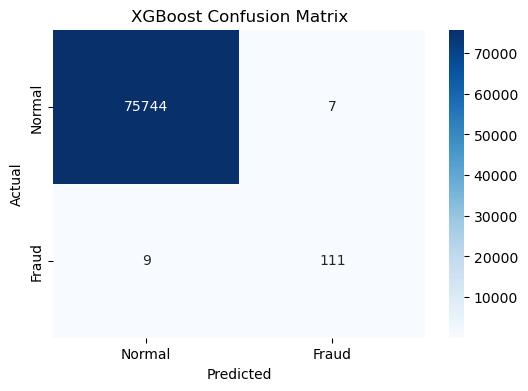

In [421]:
plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

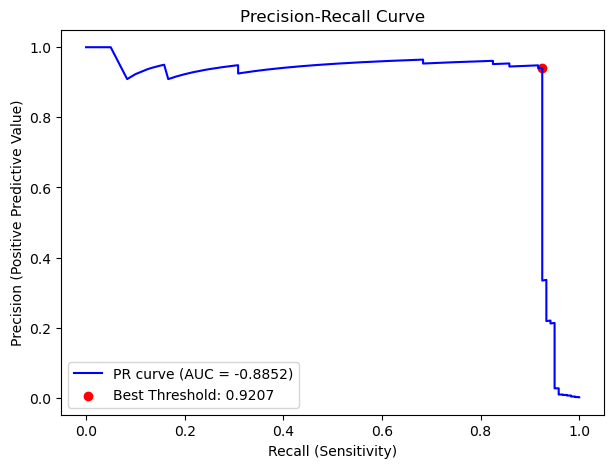

🔵 Best Threshold for Precision-Recall Balance: 0.9207


In [422]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


# Compute Precision-Recall values
precision, recall, thresholds = precision_recall_curve(y_test, xgb_scores)

# Compute F1-scores for each threshold
xgb_f1_scores = (2 * precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
xgb_optimal_idx = np.argmax(xgb_f1_scores)  # Find best threshold index
xgb_optimal_threshold = thresholds[xgb_optimal_idx]

# Plot Precision-Recall Curve
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color='blue', label=f'PR curve (AUC = {np.trapz(precision, recall):.4f})')
plt.scatter(recall[xgb_optimal_idx], precision[xgb_optimal_idx], color='red', marker='o', label=f'Best Threshold: {xgb_optimal_threshold:.4f}')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

print(f"🔵 Best Threshold for Precision-Recall Balance: {xgb_optimal_threshold:.4f}")

In [423]:
# Initialize and train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=300,        # More trees for stability
    class_weight="balanced", # Handles fraud (rare class) better
    random_state=42,
    bootstrap=False,         # Uses full dataset per tree
    n_jobs=-1                # Use all CPU cores for faster training
)


rf_model.fit(X_train_blsm, y_train_blsm)

# Predict anomalies on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate model performance
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions, digits=4))

rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")


Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9999    0.9999     75751
           1     0.9459    0.8750    0.9091       120

    accuracy                         0.9997     75871
   macro avg     0.9729    0.9375    0.9545     75871
weighted avg     0.9997    0.9997    0.9997     75871

Random Forest Accuracy: 1.00


In [424]:
from sklearn.metrics import f1_score, matthews_corrcoef, precision_recall_curve
import numpy as np

# Get predicted probabilities
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Function to find best threshold for F1 or MCC
def find_best_threshold(y_true, y_scores, metric='f1'):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_score = 0
    best_threshold = 0.5

    for t in thresholds:
        preds = (y_scores >= t).astype(int)
        score = f1_score(y_true, preds) if metric == 'f1' else matthews_corrcoef(y_true, preds)
        if score > best_score:
            best_score = score
            best_threshold = t

    return best_threshold, best_score

# Find best thresholds
xgb_best_thresh, xgb_best_f1 = find_best_threshold(y_test, xgb_probs, metric='f1')
rf_best_thresh, rf_best_f1 = find_best_threshold(y_test, rf_probs, metric='f1')

print("Best XGBoost Threshold (F1):", xgb_best_thresh, "F1:", xgb_best_f1)
print("Best RF Threshold (F1):", rf_best_thresh, "F1:", rf_best_f1)

Best XGBoost Threshold (F1): 0.86 F1: 0.9327731092436975
Best RF Threshold (F1): 0.46 F1: 0.9137931034482759


In [425]:
## Autoencoder architecture

input_layer = layers.Input(shape=(X_ae_scaled.shape[1],))
encoded = layers.Dense(256, activation='relu')(input_layer) 
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dense(128, activation='relu')(encoded) 
encoded = layers.BatchNormalization()(encoded)

encoded = layers.Dense(128, activation='relu')(encoded) 

encoded = layers.Dropout(0.2)(encoded)  # Prevent overfitting to normal transactions

decoded = layers.Dense(128, activation='relu')(encoded) 
decoded = layers.BatchNormalization()(decoded)
decoded = layers.Dense(256, activation='relu')(decoded) 

output_layer = layers.Dense(X_ae_scaled.shape[1], activation='sigmoid')(decoded)
autoencoder = Model(input_layer, output_layer)

autoencoder.compile(optimizer='adadelta', loss='mse')

#-------------

# Train the autoencoder on normal transactions only
X_train_normal = X_ae_scaled

history = autoencoder.fit(X_train_normal, X_train_normal, epochs=50, batch_size=32, shuffle=True, validation_split=0.2) 



Epoch 1/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 7s 902us/step - loss: 0.3130 - val_loss: 0.1611
Epoch 2/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 877us/step - loss: 0.1405 - val_loss: 0.1012
Epoch 3/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 862us/step - loss: 0.1075 - val_loss: 0.0852
Epoch 4/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 873us/step - loss: 0.0836 - val_loss: 0.0791
Epoch 5/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 862us/step - loss: 0.0797 - val_loss: 0.0762
Epoch 6/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 854us/step - loss: 0.0743 - val_loss: 0.0743
Epoch 7/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 864us/step - loss: 0.0748 - val_loss: 0.0732
Epoch 8/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 862us/step - loss: 0.0731 - val_loss: 0.0723
Epoch 9/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 867us/step - loss: 0.0751 - val_loss: 0.0718
Epoch 10/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 856us/step - loss: 0.0711 - val_loss: 0.0720
Epoch 11/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 6s 841us/step - loss: 0.0838 - val_loss: 0.0712
Epoch 12

In [426]:
# Predict on the actual test set
X_test_pred = autoencoder.predict(X_test)

# Calculate reconstruction error for each sample
reconstruction_error = np.mean(np.abs(X_test - X_test_pred), axis=1)

# Function to find best threshold based on F1 or MCC
from sklearn.metrics import f1_score, matthews_corrcoef

def find_best_threshold(y_true, errors, metric='f1'):
    best_thresh = 0
    best_score = 0
    for t in np.linspace(min(errors), max(errors), 100):
        preds = [1 if e > t else 0 for e in errors]
        score = f1_score(y_true, preds) if metric == 'f1' else matthews_corrcoef(y_true, preds)
        if score > best_score:
            best_score = score
            best_thresh = t
    return best_thresh, best_score

# Find the best threshold using F1
ae_best_thresh, ae_best_f1 = find_best_threshold(y_test, reconstruction_error, metric='f1')
print("Best Autoencoder Threshold (F1):", ae_best_thresh, "F1:", ae_best_f1)

# Final predictions
final_AE_predictions = [1 if error > ae_best_thresh else 0 for error in reconstruction_error]

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix (Autoencoder):")
print(confusion_matrix(y_test, final_AE_predictions))

print("Classification Report (Autoencoder):")
print(classification_report(y_test, final_AE_predictions, digits=4))


2371/2371 ━━━━━━━━━━━━━━━━━━━━ 1s 257us/step
Best Autoencoder Threshold (F1): 0.13295542451361206 F1: 0.5798319327731093
Confusion Matrix (Autoencoder):
[[75702    49]
 [   51    69]]
Classification Report (Autoencoder):
              precision    recall  f1-score   support

           0     0.9993    0.9994    0.9993     75751
           1     0.5847    0.5750    0.5798       120

    accuracy                         0.9987     75871
   macro avg     0.7920    0.7872    0.7896     75871
weighted avg     0.9987    0.9987    0.9987     75871



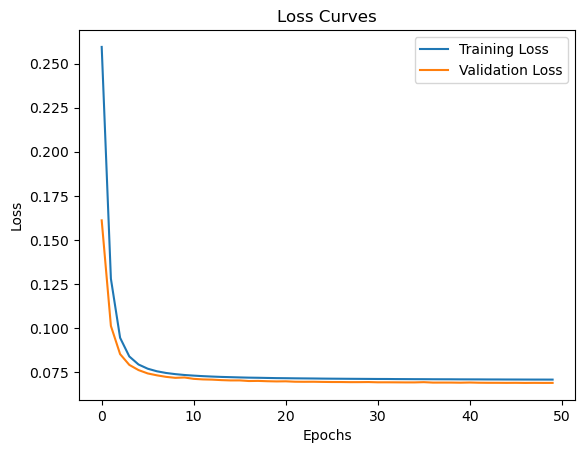

In [427]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2371/2371 ━━━━━━━━━━━━━━━━━━━━ 1s 256us/step


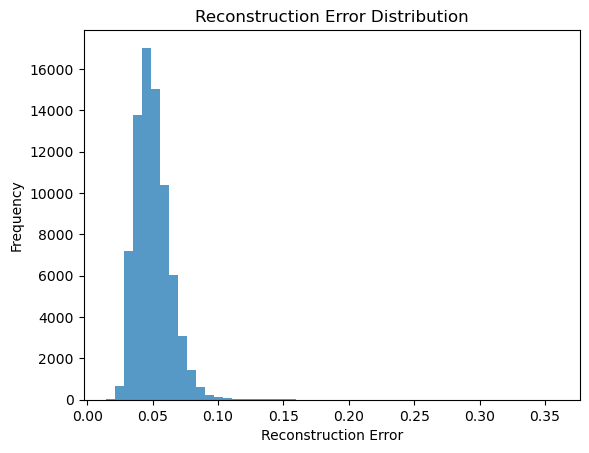

In [428]:

X_test_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.abs(X_test_pred - X_test), axis=1)

# Step 11: Visualize Reconstruction Errors
plt.hist(reconstruction_error, bins=50, alpha=0.75)
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()



In [429]:
from sklearn.metrics import f1_score, matthews_corrcoef

ae_best_thresh, ae_best_f1 = find_best_threshold(y_test, reconstruction_error, metric='f1')

print("Best Autoencoder Threshold (F1):", ae_best_thresh, "F1:", ae_best_f1)


Best Autoencoder Threshold (F1): 0.13295542451361206 F1: 0.5798319327731093


In [431]:


iso_forest = IsolationForest(contamination=0.5, n_estimators=100, random_state=42)
iso_forest.fit(X_train)
iso_forest_anomaly_scores = -iso_forest.decision_function(X_test)
iso_forest_predictions = iso_forest.predict(X_test)
iso_forest_predictions = [1 if pred == -1 else 0 for pred in iso_forest_predictions]
iso_forest_threshold = 0.06  
iso_forest_predictions = [1 if score > iso_forest_threshold else 0 for score in iso_forest_anomaly_scores]
print("Confusion Matrix (Isolation Forest):")
print(confusion_matrix(y_test, iso_forest_predictions))
print("Classification Report (Isolation Forest):")
print(classification_report(y_test, iso_forest_predictions, digits=4))


iso_scores = -iso_forest.decision_function(X_test)
iso_best_thresh, iso_best_f1 = find_best_threshold(y_test, iso_scores, metric='f1')

print("Best IsolationForest Threshold (F1):", iso_best_thresh, "F1:", iso_best_f1)



Confusion Matrix (Isolation Forest):
[[69918  5833]
 [    6   114]]
Classification Report (Isolation Forest):
              precision    recall  f1-score   support

           0     0.9999    0.9230    0.9599     75751
           1     0.0192    0.9500    0.0376       120

    accuracy                         0.9230     75871
   macro avg     0.5095    0.9365    0.4987     75871
weighted avg     0.9984    0.9230    0.9585     75871

Best IsolationForest Threshold (F1): 0.21513122518778727 F1: 0.4153846153846154


In [432]:
iso_scores = -iso_forest.decision_function(X_test)
iso_best_thresh, iso_best_f1 = find_best_threshold(y_test, iso_scores, metric='f1')
print("Best IsolationForest Threshold (F1):", iso_best_thresh, "F1:", iso_best_f1)


Best IsolationForest Threshold (F1): 0.21513122518778727 F1: 0.4153846153846154


In [433]:

### Weighted Averaging of Anomaly Scores

weights = {
    'autoencoder': 0.18,       
    'isolation_forest': 0.13,  
    'xgboost': 0.52,  
    'random_forest': 0.18 
}


weighted_scores = (weights['autoencoder'] * reconstruction_error) + \
                  (weights['isolation_forest'] * iso_forest_anomaly_scores) + \
                  (weights['xgboost'] * xgb_scores) + \
                  (weights['random_forest'] * rf_scores)


weighted_threshold = np.percentile(weighted_scores, 99.848) 

# Apply the best threshold for final fraud predictions
best_threshold = 0.56 
final_predictions_weighted = (weighted_scores > best_threshold).astype(int)

# Evaluate the weighted predictions
print("Evaluation of Weighted Averaging of Anomaly Scores:")
print(confusion_matrix(y_test, final_predictions_weighted))
print(classification_report(y_test, final_predictions_weighted, digits=4))


from imblearn.metrics import specificity_score
from sklearn.metrics import matthews_corrcoef

tnr = specificity_score(y_test, final_predictions_weighted)
print(f"TNR: {tnr:.4f}")

mcc = matthews_corrcoef(y_test, final_predictions_weighted)
print(f"MCC: {mcc:.4f}")

Evaluation of Weighted Averaging of Anomaly Scores:
[[75745     6]
 [    9   111]]
              precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999     75751
           1     0.9487    0.9250    0.9367       120

    accuracy                         0.9998     75871
   macro avg     0.9743    0.9625    0.9683     75871
weighted avg     0.9998    0.9998    0.9998     75871

TNR: 0.9999
MCC: 0.9367


In [434]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    matthews_corrcoef, precision_score, recall_score, f1_score
)

def evaluate_all_metrics(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    print("Confusion Matrix:")
    print(f"TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")
    print()
    print("Metrics:")
    print(f"TPR (Recall):      {TPR:.4f}")
    print(f"TNR (Specificity): {TNR:.4f}")
    print(f"Precision:         {precision:.4f}")
    print(f"F1-score:          {f1:.4f}")
    print(f"MCC:               {mcc:.4f}")


In [435]:
evaluate_all_metrics(y_test, final_predictions_weighted)


Confusion Matrix:
TN: 75745, FP: 6, FN: 9, TP: 111

Metrics:
TPR (Recall):      0.9250
TNR (Specificity): 0.9999
Precision:         0.9487
F1-score:          0.9367
MCC:               0.9367


In [436]:
from sklearn.metrics import f1_score
from itertools import product
import numpy as np


ae = np.array(reconstruction_error)
iso = np.array(iso_forest_anomaly_scores)
xgb = np.array(xgb_scores)
rf = np.array(rf_scores)


best_score = 0
best_weights = None
best_threshold = 0.5  


for w_ae, w_iso, w_xgb, w_rf in product(np.arange(0, 1.1, 0.2), repeat=4):
    if abs(w_ae + w_iso + w_xgb + w_rf - 1.0) > 0.05:
        continue  # skip if weights don't sum approximately to 1

    weighted_scores = (
        w_ae * ae +
        w_iso * iso +
        w_xgb * xgb +
        w_rf * rf
    )

    # Try several thresholds for this weight combo
    for threshold in np.linspace(0.1, 0.9, 9):
        preds = (weighted_scores >= threshold).astype(int)
        score = f1_score(y_test, preds)

        if score > best_score:
            best_score = score
            best_weights = {
                'autoencoder': w_ae,
                'isolation_forest': w_iso,
                'xgboost': w_xgb,
                'random_forest': w_rf
            }
            best_threshold = threshold


In [437]:
final_weighted_scores = (
    best_weights['autoencoder'] * ae +
    best_weights['isolation_forest'] * iso +
    best_weights['xgboost'] * xgb +
    best_weights['random_forest'] * rf
)

final_preds = (final_weighted_scores >= best_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, final_preds))
print(classification_report(y_test, final_preds, digits=4))


[[75746     5]
 [    9   111]]
              precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999     75751
           1     0.9569    0.9250    0.9407       120

    accuracy                         0.9998     75871
   macro avg     0.9784    0.9625    0.9703     75871
weighted avg     0.9998    0.9998    0.9998     75871



In [438]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    matthews_corrcoef, precision_score, recall_score, f1_score
)

def evaluate_all_metrics(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    print("Confusion Matrix:")
    print(f"TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")
    print()
    print("Metrics:")
    print(f"TPR (Recall):      {TPR:.4f}")
    print(f"TNR (Specificity): {TNR:.4f}")
    print(f"Precision:         {precision:.4f}")
    print(f"F1-score:          {f1:.4f}")
    print(f"MCC:               {mcc:.4f}")


In [439]:
evaluate_all_metrics(y_test, final_preds)


Confusion Matrix:
TN: 75746, FP: 5, FN: 9, TP: 111

Metrics:
TPR (Recall):      0.9250
TNR (Specificity): 0.9999
Precision:         0.9569
F1-score:          0.9407
MCC:               0.9407


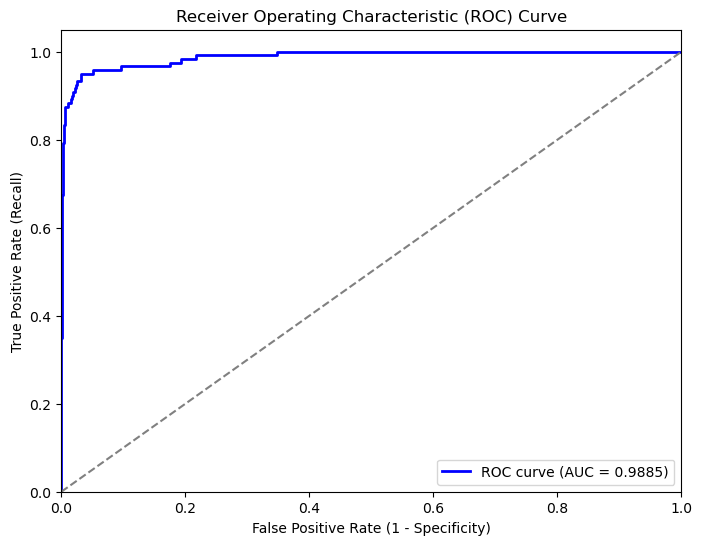

AUC-ROC Score: 0.9885
Optimal Threshold from Precision-Recall Curve: 0.1394


In [440]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
import numpy as np

# Compute ROC curve and AUC for weighted anomaly scores
fpr, tpr, thresholds = roc_curve(y_test, weighted_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC Score
print(f"AUC-ROC Score: {roc_auc:.4f}")


from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, weighted_scores)

# Find the threshold where precision and recall are balanced
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)  # Find the best F1 score
optimal_threshold_pr = thresholds[optimal_idx]

print(f"Optimal Threshold from Precision-Recall Curve: {optimal_threshold_pr:.4f}")



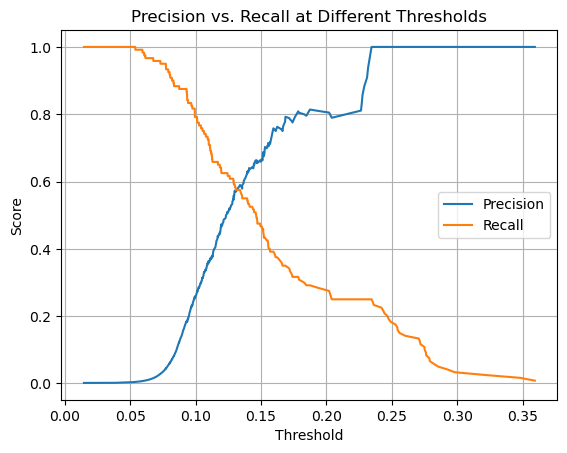

In [441]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, weighted_scores)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs. Recall at Different Thresholds')
plt.legend()
plt.grid()
plt.show()